In [6]:
import numpy as np 
import pandas as pd 
import optuna as opt
from skopt.space import Integer, Real
from sklearn.model_selection import train_test_split, KFold, cross_val_score
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline
from xgboost import XGBClassifier
from lightgbm import LGBMClassifier
from catboost import CatBoostClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.preprocessing import StandardScaler
from category_encoders import TargetEncoder
from sklearn.model_selection import (
    train_test_split, 
    cross_val_score, 
    GridSearchCV,
    RandomizedSearchCV
)
from sklearn.metrics import precision_score, confusion_matrix, recall_score, precision_recall_curve, auc, roc_auc_score, f1_score, accuracy_score
from sklearn.model_selection import StratifiedKFold
from category_encoders import CatBoostEncoder
from sklearn.impute import SimpleImputer
from sklearn.pipeline import Pipeline
import warnings
warnings.filterwarnings('ignore')
#Bibliotecas para EDA
import matplotlib.pyplot as plt
import seaborn as sns
import plotly.express as px
import plotly.graph_objects as go
from ipywidgets import interact
import ipywidgets as widgets
import joblib
from sklearn.ensemble import RandomForestRegressor
import joblib

In [8]:
df_churn = pd.read_csv('dataset/train.csv')

FileNotFoundError: [Errno 2] No such file or directory: 'dataset/train.csv'

## Modelagem    

In [5]:
df_churn.head()

NameError: name 'df_churn' is not defined

In [15]:
df_churn.describe()

,id,CustomerId,CreditScore,Age,Tenure,Balance,NumOfProducts,HasCrCard,IsActiveMember,EstimatedSalary,Exited
count,165034.0000,1.650340e+05,165034.000000,165034.000000,165034.000000,165034.000000,165034.000000,165034.000000,165034.000000,165034.000000,165034.000000
mean,82516.5000,1.569201e+07,656.454373,38.125888,5.020353,55478.086689,1.554455,0.753954,0.497770,112574.822734,0.211599
std,47641.3565,7.139782e+04,80.103340,8.867205,2.806159,62817.663278,0.547154,0.430707,0.499997,50292.865585,0.408443
min,0.0000,1.556570e+07,350.000000,18.000000,0.000000,0.000000,1.000000,0.000000,0.000000,11.580000,0.000000
25%,41258.2500,1.563314e+07,597.000000,32.000000,3.000000,0.000000,1.000000,1.000000,0.000000,74637.570000,0.000000
50%,82516.5000,1.569017e+07,659.000000,37.000000,5.000000,0.000000,2.000000,1.000000,0.000000,117948.000000,0.000000
75%,123774.7500,1.575682e+07,710.000000,42.000000,7.000000,119939.517500,2.000000,1.000000,1.000000,155152.467500,0.000000
max,165033.0000,1.581569e+07,850.000000,92.000000,10.000000,250898.090000,4.000000,1.000000,1.000000,199992.480000,1.000000


In [16]:
df_churn.Exited.value_counts(1)

Exited
0    0.788401
1    0.211599
Name: proportion, dtype: float64

In [29]:
X = df_churn.drop(['id', 'Exited','CustomerId','Surname'], axis=1)
y = df_churn['Exited']

Os dados estão desbalanceados, sendo necessario utilizar alguma estrategia para lidar com esse problema

In [18]:
peso = df_churn.Exited.value_counts(1)[0]/df_churn.Exited.value_counts(1)[1]
peso    

3.72592422897397

In [31]:
X.head()

,CreditScore,Geography,Gender,Age,Tenure,Balance,NumOfProducts,HasCrCard,IsActiveMember,EstimatedSalary
0,668,France,Male,33.0,3,0.00,2,1.0,0.0,181449.97
1,627,France,Male,33.0,1,0.00,2,1.0,1.0,49503.50
2,678,France,Male,40.0,10,0.00,2,1.0,0.0,184866.69
3,581,France,Male,34.0,2,148882.54,1,1.0,1.0,84560.88
4,716,Spain,Male,33.0,5,0.00,2,1.0,1.0,15068.83


In [19]:
xgb = XGBClassifier(n_estimators = 1000, max_depth = 8, learning_rate = 1e-3, n_jobs = -1, random_state = 0, scale_pos_weight = peso, eval_metrics = True)
lgb = LGBMClassifier(n_estimators = 1000, max_depth = 8, learning_rate = 1e-3, n_jobs = -1, random_state = 0, is_unbalance = True, verbose=-1)
catbost = CatBoostClassifier(n_estimators=1000, max_depth=8, learning_rate=1e-3, scale_pos_weight=peso, random_state=0, verbose=0)
lgr = LogisticRegression(random_state=0, class_weight='balanced', n_jobs=-1, solver='lbfgs', max_iter=1000)

In [20]:
'''k = 5
thershold = 0.5
folds = StratifiedKFold(n_splits=k, shuffle=True, random_state=42)

precisoes = list()
revocacos = list()
acuracia = list()
medida_f1 = list()
precision_recall_auc = list()
rocs_auc = list()

for fold, (train_index, test_index) in enumerate(folds.split(X, y)):
    print('=-'*7 + f' Folds: {fold+1} ' + '=-'*7)

    X_train_interno, y_train_interno = X.iloc[train_index, :], y.iloc[train_index]
    X_test_interno, y_test_interno = X.iloc[test_index, :], y.iloc[test_index]

    encoder = CatBoostEncoder()

    cat_imputer = SimpleImputer(strategy='most_frequent')
    num_imputer = SimpleImputer(strategy='median')

    cat_pipeline = Pipeline([('encoder', encoder), ('imputer', cat_imputer)])
    num_pipeline = Pipeline([('imputer', num_imputer)])

    cat_cols = X_train_interno.select_dtypes(include=['object']).columns
    num_cols = X_train_interno.select_dtypes(exclude=['object']).columns

    X_train_interno[cat_cols] = cat_pipeline.fit_transform(X_train_interno[cat_cols], y_train_interno)
    X_train_interno[num_cols] = num_pipeline.fit_transform(X_train_interno[num_cols])

    X_test_interno[cat_cols] = cat_pipeline.transform(X_test_interno[cat_cols])
    X_test_interno[num_cols] = num_pipeline.transform(X_test_interno[num_cols])

    xgb.fit(X_train_interno, y_train_interno)

    y_pred_proba = xgb.predict_proba(X_test_interno)[:, 1]
    y_pred = np.where(y_pred_proba > thershold, 1, 0)  # Corrigido aqui

    precisao, revocacao, limiares = precision_recall_curve(y_test_interno, y_pred)

    precisao_revocacao_auc = auc(revocacao, precisao)
    roc_auc = roc_auc_score(y_test_interno, y_pred_proba)
    acuracia_score = accuracy_score(y_test_interno, y_pred)
    precisao_score = precision_score(y_test_interno, y_pred)
    revocacao_score = recall_score(y_test_interno, y_pred)
    f1score = f1_score(y_test_interno, y_pred)

    precisoes.append(precisao_score)
    revocacos.append(revocacao_score)  # Corrigido aqui
    acuracia.append(acuracia_score)
    precision_recall_auc.append(precisao_revocacao_auc)
    medida_f1.append(f1score)
    rocs_auc.append(roc_auc)

    print(f'Precisão: {precisao_score:.3f}')
    print(f'Revocação: {revocacao_score:.3f}')
    print(f'Acuracia: {acuracia_score:.3f}')
    print(f'Medida f1: {f1score:.3f}')
    print(f'Precisiona recall auc: {precisao_revocacao_auc:.3f}')
    print(f'ROC AUC: {roc_auc:.3f}')
'''

"k = 5\nthershold = 0.5\nfolds = StratifiedKFold(n_splits=k, shuffle=True, random_state=42)\n\nprecisoes = list()\nrevocacos = list()\nacuracia = list()\nmedida_f1 = list()\nprecision_recall_auc = list()\nrocs_auc = list()\n\nfor fold, (train_index, test_index) in enumerate(folds.split(X, y)):\n    print('=-'*7 + f' Folds: {fold+1} ' + '=-'*7)\n\n    X_train_interno, y_train_interno = X.iloc[train_index, :], y.iloc[train_index]\n    X_test_interno, y_test_interno = X.iloc[test_index, :], y.iloc[test_index]\n\n    encoder = CatBoostEncoder()\n\n    cat_imputer = SimpleImputer(strategy='most_frequent')\n    num_imputer = SimpleImputer(strategy='median')\n\n    cat_pipeline = Pipeline([('encoder', encoder), ('imputer', cat_imputer)])\n    num_pipeline = Pipeline([('imputer', num_imputer)])\n\n    cat_cols = X_train_interno.select_dtypes(include=['object']).columns\n    num_cols = X_train_interno.select_dtypes(exclude=['object']).columns\n\n    X_train_interno[cat_cols] = cat_pipeline.fit_

In [21]:
'''precisoes = np.array(precisoes)
revocacos = np.array(revocacos)
acuracia = np.array(acuracia)
medida_f1 = np.array(medida_f1)
precision_recall_auc = np.array(precision_recall_auc)
rocs_auc = np.array(rocs_auc)

media_previsoes = np.mean(precisoes)
media_revocacoes = np.mean(revocacos)
media_acuracia = np.mean(acuracia)
media_f1 = np.mean(precisao_revocacao_auc)
media_rocs_auc = np.mean(rocs_auc)

std_previsoes = np.std(precisoes)
std_revocacoes = np.std(revocacos)
std_acuracia = np.std(acuracia)
std_f1 = np.std(precisao_revocacao_auc)
std_rocs_auc = np.std(rocs_auc)


print()
print('=-'*6 + 'Exibindo a media das metricas obtidas' + '=-'*6)
print(f'Media da precisão: {media_previsoes:.3f} +/- {std_previsoes:.3f}')
print(f'Media da precisão: {media_revocacoes:.3f} +/- {std_revocacoes:.3f}')
print(f'Media da precisão: {media_acuracia:.3f} +/- {std_acuracia:.3f}')
print(f'Media da precisão: {media_f1:.3f} +/- {std_f1:.3f}')
print(f'Media da precisão: {media_rocs_auc:.3f} +/- {std_rocs_auc:.3f}')
'''

NameError: name 'precisoes' is not defined

In [26]:
def trainer(X, y, k, model):
    thershold = 0.5
    # Inicializando a função StratifiedKFold
    folds = StratifiedKFold(n_splits = k, shuffle = True, random_state = 42)

    # Criando listas para armazenar os valores de precisão, revocação, acurácia, medida-F1, precision_recall_auc e roc_auc
    # em cada fold
    precisoes = list()
    revocacoes = list()
    acuracias = list()
    Medida_F1 = list()
    precision_recall_auc = list()
    rocs_auc = list()
    cm_total = np.zeros((2,2))

    # Será aplicado o método "split" no objeto folds, que retornará uma lista 
    # com os índices das instâncias que pertencem ao conjunto de treino e 
    # outra com os índices das instâncias que pertencem ao conjunto de teste
    
    for k, (train_index, test_index) in enumerate(folds.split(X, y)):
        print("=-"*7 + f"Fold: {k + 1}" + "=-"*7)

        # Dividindo os dados em treino e teste para cada um dos folds
        X_train_interno, y_train_interno = X.iloc[train_index, :], y.iloc[train_index]
        X_test_interno, y_test_interno = X.iloc[test_index, :], y.iloc[test_index]
                
        # train_index e test_index: São os índices das instâncias do conjunto 
        # de treino e teste, respectivamente, selecionados em cada um dos folds
        
        ###########################################
        ############## Preprocessing ##############
        ###########################################
    
        # Instanciando o CatBoost Encoder
        encoder = CatBoostEncoder()

        # Criando um imputer para preencher com a moda os valores faltantes de variáveis categóricas
        cat_imputer = SimpleImputer(strategy = 'most_frequent')

        # Criando um imputer para preencher com a mediana os valores faltantes de variáveis numéricas
        num_imputer = SimpleImputer(strategy = 'median')

        # Criando pipelines para variáveis categóricas e numéricas que preenche os valores faltantes
        cat_pipeline = Pipeline([('encoder', encoder), ('imputer', cat_imputer)])
        num_pipeline = Pipeline([('imputer', num_imputer)])

        # Identifica as variáveis categóricas e numéricas
        cat_cols = X_train_interno.select_dtypes(include = ['object']).columns
        num_cols = X_train_interno.select_dtypes(exclude = ['object']).columns

        # Aplicando os pipelines no conjunto de treinamento para preencher valores faltantes em colunas categóricas e numéricas
        X_train_interno[cat_cols] = cat_pipeline.fit_transform(X_train_interno[cat_cols], y_train_interno)
        X_train_interno[num_cols] = num_pipeline.fit_transform(X_train_interno[num_cols])

        # Aplicando os pipelines ao conjunto de teste para preencher valores faltantes em colunas categóricas e numéricas
        X_test_interno[cat_cols] = cat_pipeline.transform(X_test_interno[cat_cols])
        X_test_interno[num_cols] = num_pipeline.transform(X_test_interno[num_cols])

        # Treinando o modelo
        model.fit(X_train_interno, y_train_interno)
        joblib.dump(model, 'modelo_treinado.joblib')

        # Obtendo as probabilidades relacionadas a classe 1
        y_pred_proba = model.predict_proba(X_test_interno)[:,1]

        # Obtendo as previsões do modelo
        y_pred = np.where(y_pred_proba > thershold, 1, 0)

        # Calculando a precisão e revocação para determinar a precision_recall_auc
        precisao, revocacao, limiares = precision_recall_curve(y_test_interno, y_pred)

        # Determinando as métricas para cada fold
        cm_total += confusion_matrix(y_test_interno, y_pred)
        precisao_revocacao_auc = auc(revocacao, precisao)
        roc_auc = roc_auc_score(y_test_interno, y_pred_proba)
        acuracia_score = accuracy_score(y_test_interno, y_pred)
        precisao_score = precision_score(y_test_interno, y_pred)
        revocacao_score = recall_score(y_test_interno, y_pred)
        f1score = f1_score(y_test_interno, y_pred)

        # Armazenando as métricas nas listas criadas
        precisoes.append(precisao_score)
        revocacoes.append(revocacao_score)
        precision_recall_auc.append(precisao_revocacao_auc)
        rocs_auc.append(roc_auc)
        acuracias.append(acuracia_score)
        Medida_F1.append(f1score)

        # Exibindo as métricas para cada um dos folds
        print(f"Precisão: {precisao_score:.3f}")
        print(f"Revocação: {revocacao_score:.3f}")
        print(f"Acurácia: {acuracia_score:.3f}")
        print(f"Medida F1: {f1score:.3f}")
        print(f"Precision_recall AUC: {precisao_revocacao_auc:.3f}")
        print(f"ROC AUC: {roc_auc:.3f}")

    # Transformando as listas em arrays para fazer operações matemáticas
    precisoes = np.array(precisoes)
    revocacoes = np.array(revocacoes)
    acuracias = np.array(acuracias)
    Medida_F1 = np.array(Medida_F1)
    precision_recall_auc = np.array(precision_recall_auc)
    rocs_auc = np.array(rocs_auc)

    # Calculando as médias das métricas
    media_precisao = np.mean(precisoes)
    media_revocacao = np.mean(revocacoes)
    media_acuracia = np.mean(acuracias)
    media_F1 = np.mean(Medida_F1)
    media_pr_AUC = np.mean(precision_recall_auc)
    media_roc_AUC = np.mean(rocs_auc)

    # Calculando os desvios padrão para cada métrica
    std_precisao = np.std(precisoes)
    std_revocacao = np.std(revocacoes)
    std_acuracia = np.std(acuracias)
    std_F1 = np.std(Medida_F1)
    std_pr_AUC = np.std(precision_recall_auc)
    std_roc_AUC = np.std(rocs_auc)

    # Exibindo as médias das métricas obtidas
    print()
    print("=-"*6 + "Exibindo a média das métricas obtidas" + "-="*6)
    print(f"Média da precisão: {media_precisao:.3f} +/- {std_precisao:.3f}")
    print(f"Média da revocação: {media_revocacao:.3f} +/- {std_revocacao:.3f}")
    print(f"Média da acurácia: {media_acuracia:.3f} +/- {std_acuracia:.3f}")
    print(f"Média da Medida F1: {media_F1:.3f} +/- {std_F1:.3f}")
    print(f"Média da Precision/Recall AUC: {media_pr_AUC:.3f} +/- {std_pr_AUC:.3f}")
    print(f"Média da ROC AUC: {media_roc_AUC:.3f} +/- {std_roc_AUC:.3f}")

    # Plotando a matriz de confusão
    plt.figure(figsize = (8,6))
    sns.heatmap(cm_total, annot=True, fmt = ".0f", cmap = 'Blues')
    plt.title("Matriz de Confusão de Todos os Folds")
    plt.ylabel('Verdadeiro')
    plt.xlabel('Previsto')
    plt.show()

    joblib.dump(model, 'modelo_treinado.joblib')

In [23]:
def tunagem(trial, k=5, thershold=0.5):
    # Tunagem dos hiperparâmetros
    learning_rate = trial.suggest_float('learning_rate', 1e-3, 1e-1, log=True)
    max_depth = trial.suggest_int('max_depth', 1, 20)
    subsample = trial.suggest_float('subsample', 0, 1, step=0.1)
    colsample_bytree = trial.suggest_float('colsample_bytree', 0, 1, step=0.1)
    min_child_weight = trial.suggest_int('min_child_weight', 1, 20)
    n_estimators = trial.suggest_int('n_estimators', 100, 2000)
    folds = StratifiedKFold(n_splits=k, shuffle=True, random_state=42)

    precisoes = list()
    revocacos = list()
    acuracia = list()
    medida_f1 = list()
    precision_recall_auc = list()
    rocs_auc = list()

    for fold, (train_index, test_index) in enumerate(folds.split(X, y)):
        print('=-'*7 + f' Folds: {fold+1} ' + '=-'*7)

        X_train_interno, y_train_interno = X.iloc[train_index, :], y.iloc[train_index]
        X_test_interno, y_test_interno = X.iloc[test_index, :], y.iloc[test_index]

        encoder = CatBoostEncoder()

        cat_imputer = SimpleImputer(strategy='most_frequent')
        num_imputer = SimpleImputer(strategy='median')

        cat_pipeline = Pipeline([('encoder', encoder), ('imputer', cat_imputer)])
        num_pipeline = Pipeline([('imputer', num_imputer)])

        cat_cols = X_train_interno.select_dtypes(include=['object']).columns
        num_cols = X_train_interno.select_dtypes(exclude=['object']).columns

        X_train_interno[cat_cols] = cat_pipeline.fit_transform(X_train_interno[cat_cols], y_train_interno)
        X_train_interno[num_cols] = num_pipeline.fit_transform(X_train_interno[num_cols])

        X_test_interno[cat_cols] = cat_pipeline.transform(X_test_interno[cat_cols])
        X_test_interno[num_cols] = num_pipeline.transform(X_test_interno[num_cols])

        xgb = XGBClassifier(n_estimators=n_estimators, max_depth=max_depth, learning_rate=learning_rate, n_jobs=-1,
                            random_state=0, scale_pos_weight=peso, eval_metrics=True,
                            subsample=subsample, colsample_bytree=colsample_bytree, min_child_weight=min_child_weight
                            )
        xgb.fit(X_train_interno, y_train_interno)

        y_pred_proba = xgb.predict_proba(X_test_interno)[:, 1]
        y_pred = np.where(y_pred_proba > thershold, 1, 0)  # Corrigido aqui

        precisao, revocacao, limiares = precision_recall_curve(y_test_interno, y_pred)

        precisao_revocacao_auc = auc(revocacao, precisao)
        roc_auc = roc_auc_score(y_test_interno, y_pred_proba)
        acuracia_score = accuracy_score(y_test_interno, y_pred)
        precisao_score = precision_score(y_test_interno, y_pred)
        revocacao_score = recall_score(y_test_interno, y_pred)
        f1score = f1_score(y_test_interno, y_pred)

        precisoes.append(precisao_score)
        revocacos.append(revocacao_score)  # Corrigido aqui
        acuracia.append(acuracia_score)
        precision_recall_auc.append(precisao_revocacao_auc)
        medida_f1.append(f1score)
        rocs_auc.append(roc_auc)

    precisoes = np.array(precisoes)
    revocacos = np.array(revocacos)
    acuracia = np.array(acuracia)
    medida_f1 = np.array(medida_f1)
    precision_recall_auc = np.array(precision_recall_auc)
    rocs_auc = np.array(rocs_auc)

    media_previsoes = np.mean(precisoes)
    media_revocacoes = np.mean(revocacos)
    media_acuracia = np.mean(acuracia)
    media_f1 = np.mean(precisao_revocacao_auc)
    media_rocs_auc = np.mean(rocs_auc)
    
    # Salvando os melhores hiperparâmetros
    best_params = trial.params
    print("Melhores hiperparâmetros encontrados:", best_params)
    return media_revocacoes
study = opt.create_study(direction='maximize')
study.optimize(tunagem, n_trials=50)


[I 2024-04-04 15:46:49,623] A new study created in memory with name: no-name-f915865e-3e1a-4e41-9ce1-5a0f4fef3f10


=-=-=-=-=-=-=- Folds: 1 =-=-=-=-=-=-=-
=-=-=-=-=-=-=- Folds: 2 =-=-=-=-=-=-=-
=-=-=-=-=-=-=- Folds: 3 =-=-=-=-=-=-=-
=-=-=-=-=-=-=- Folds: 4 =-=-=-=-=-=-=-
=-=-=-=-=-=-=- Folds: 5 =-=-=-=-=-=-=-


[I 2024-04-04 15:46:55,090] Trial 0 finished with value: 0.8 and parameters: {'learning_rate': 0.0041001699090813856, 'max_depth': 6, 'subsample': 0.0, 'colsample_bytree': 0.7000000000000001, 'min_child_weight': 18, 'n_estimators': 176}. Best is trial 0 with value: 0.8.


Melhores hiperparâmetros encontrados: {'learning_rate': 0.0041001699090813856, 'max_depth': 6, 'subsample': 0.0, 'colsample_bytree': 0.7000000000000001, 'min_child_weight': 18, 'n_estimators': 176}
=-=-=-=-=-=-=- Folds: 1 =-=-=-=-=-=-=-
=-=-=-=-=-=-=- Folds: 2 =-=-=-=-=-=-=-
=-=-=-=-=-=-=- Folds: 3 =-=-=-=-=-=-=-
=-=-=-=-=-=-=- Folds: 4 =-=-=-=-=-=-=-
=-=-=-=-=-=-=- Folds: 5 =-=-=-=-=-=-=-


[I 2024-04-04 15:49:14,972] Trial 1 finished with value: 0.7768964546020314 and parameters: {'learning_rate': 0.00770127212731791, 'max_depth': 12, 'subsample': 0.2, 'colsample_bytree': 0.5, 'min_child_weight': 16, 'n_estimators': 660}. Best is trial 0 with value: 0.8.


Melhores hiperparâmetros encontrados: {'learning_rate': 0.00770127212731791, 'max_depth': 12, 'subsample': 0.2, 'colsample_bytree': 0.5, 'min_child_weight': 16, 'n_estimators': 660}
=-=-=-=-=-=-=- Folds: 1 =-=-=-=-=-=-=-
=-=-=-=-=-=-=- Folds: 2 =-=-=-=-=-=-=-
=-=-=-=-=-=-=- Folds: 3 =-=-=-=-=-=-=-
=-=-=-=-=-=-=- Folds: 4 =-=-=-=-=-=-=-
=-=-=-=-=-=-=- Folds: 5 =-=-=-=-=-=-=-


[I 2024-04-04 15:52:23,724] Trial 2 finished with value: 0.7953094136428822 and parameters: {'learning_rate': 0.002440734335883991, 'max_depth': 8, 'subsample': 0.7000000000000001, 'colsample_bytree': 0.8, 'min_child_weight': 2, 'n_estimators': 991}. Best is trial 0 with value: 0.8.


Melhores hiperparâmetros encontrados: {'learning_rate': 0.002440734335883991, 'max_depth': 8, 'subsample': 0.7000000000000001, 'colsample_bytree': 0.8, 'min_child_weight': 2, 'n_estimators': 991}
=-=-=-=-=-=-=- Folds: 1 =-=-=-=-=-=-=-
=-=-=-=-=-=-=- Folds: 2 =-=-=-=-=-=-=-
=-=-=-=-=-=-=- Folds: 3 =-=-=-=-=-=-=-
=-=-=-=-=-=-=- Folds: 4 =-=-=-=-=-=-=-
=-=-=-=-=-=-=- Folds: 5 =-=-=-=-=-=-=-


[I 2024-04-04 15:54:29,492] Trial 3 finished with value: 0.7975144537345203 and parameters: {'learning_rate': 0.0025794010387732926, 'max_depth': 7, 'subsample': 0.4, 'colsample_bytree': 0.5, 'min_child_weight': 4, 'n_estimators': 901}. Best is trial 0 with value: 0.8.


Melhores hiperparâmetros encontrados: {'learning_rate': 0.0025794010387732926, 'max_depth': 7, 'subsample': 0.4, 'colsample_bytree': 0.5, 'min_child_weight': 4, 'n_estimators': 901}
=-=-=-=-=-=-=- Folds: 1 =-=-=-=-=-=-=-
=-=-=-=-=-=-=- Folds: 2 =-=-=-=-=-=-=-
=-=-=-=-=-=-=- Folds: 3 =-=-=-=-=-=-=-
=-=-=-=-=-=-=- Folds: 4 =-=-=-=-=-=-=-
=-=-=-=-=-=-=- Folds: 5 =-=-=-=-=-=-=-


[I 2024-04-04 15:54:42,498] Trial 4 finished with value: 0.7969415192594833 and parameters: {'learning_rate': 0.05351738788726471, 'max_depth': 1, 'subsample': 0.5, 'colsample_bytree': 0.9, 'min_child_weight': 3, 'n_estimators': 196}. Best is trial 0 with value: 0.8.


Melhores hiperparâmetros encontrados: {'learning_rate': 0.05351738788726471, 'max_depth': 1, 'subsample': 0.5, 'colsample_bytree': 0.9, 'min_child_weight': 3, 'n_estimators': 196}
=-=-=-=-=-=-=- Folds: 1 =-=-=-=-=-=-=-
=-=-=-=-=-=-=- Folds: 2 =-=-=-=-=-=-=-
=-=-=-=-=-=-=- Folds: 3 =-=-=-=-=-=-=-
=-=-=-=-=-=-=- Folds: 4 =-=-=-=-=-=-=-
=-=-=-=-=-=-=- Folds: 5 =-=-=-=-=-=-=-


[I 2024-04-04 15:57:11,908] Trial 5 finished with value: 0.7902409352064356 and parameters: {'learning_rate': 0.004486993808253369, 'max_depth': 9, 'subsample': 0.8, 'colsample_bytree': 0.0, 'min_child_weight': 15, 'n_estimators': 1361}. Best is trial 0 with value: 0.8.


Melhores hiperparâmetros encontrados: {'learning_rate': 0.004486993808253369, 'max_depth': 9, 'subsample': 0.8, 'colsample_bytree': 0.0, 'min_child_weight': 15, 'n_estimators': 1361}
=-=-=-=-=-=-=- Folds: 1 =-=-=-=-=-=-=-
=-=-=-=-=-=-=- Folds: 2 =-=-=-=-=-=-=-
=-=-=-=-=-=-=- Folds: 3 =-=-=-=-=-=-=-
=-=-=-=-=-=-=- Folds: 4 =-=-=-=-=-=-=-
=-=-=-=-=-=-=- Folds: 5 =-=-=-=-=-=-=-


[I 2024-04-04 15:59:14,903] Trial 6 finished with value: 0.7881794034180591 and parameters: {'learning_rate': 0.019725951895898267, 'max_depth': 13, 'subsample': 0.1, 'colsample_bytree': 0.0, 'min_child_weight': 17, 'n_estimators': 1088}. Best is trial 0 with value: 0.8.


Melhores hiperparâmetros encontrados: {'learning_rate': 0.019725951895898267, 'max_depth': 13, 'subsample': 0.1, 'colsample_bytree': 0.0, 'min_child_weight': 17, 'n_estimators': 1088}
=-=-=-=-=-=-=- Folds: 1 =-=-=-=-=-=-=-
=-=-=-=-=-=-=- Folds: 2 =-=-=-=-=-=-=-
=-=-=-=-=-=-=- Folds: 3 =-=-=-=-=-=-=-
=-=-=-=-=-=-=- Folds: 4 =-=-=-=-=-=-=-
=-=-=-=-=-=-=- Folds: 5 =-=-=-=-=-=-=-


[I 2024-04-04 16:00:36,688] Trial 7 finished with value: 0.788551404129779 and parameters: {'learning_rate': 0.008219764678100405, 'max_depth': 8, 'subsample': 0.30000000000000004, 'colsample_bytree': 0.2, 'min_child_weight': 8, 'n_estimators': 559}. Best is trial 0 with value: 0.8.


Melhores hiperparâmetros encontrados: {'learning_rate': 0.008219764678100405, 'max_depth': 8, 'subsample': 0.30000000000000004, 'colsample_bytree': 0.2, 'min_child_weight': 8, 'n_estimators': 559}
=-=-=-=-=-=-=- Folds: 1 =-=-=-=-=-=-=-
=-=-=-=-=-=-=- Folds: 2 =-=-=-=-=-=-=-
=-=-=-=-=-=-=- Folds: 3 =-=-=-=-=-=-=-
=-=-=-=-=-=-=- Folds: 4 =-=-=-=-=-=-=-
=-=-=-=-=-=-=- Folds: 5 =-=-=-=-=-=-=-


[I 2024-04-04 16:02:43,082] Trial 8 finished with value: 0.7467999050493571 and parameters: {'learning_rate': 0.0778466451059535, 'max_depth': 6, 'subsample': 0.4, 'colsample_bytree': 0.9, 'min_child_weight': 1, 'n_estimators': 1283}. Best is trial 0 with value: 0.8.


Melhores hiperparâmetros encontrados: {'learning_rate': 0.0778466451059535, 'max_depth': 6, 'subsample': 0.4, 'colsample_bytree': 0.9, 'min_child_weight': 1, 'n_estimators': 1283}
=-=-=-=-=-=-=- Folds: 1 =-=-=-=-=-=-=-
=-=-=-=-=-=-=- Folds: 2 =-=-=-=-=-=-=-
=-=-=-=-=-=-=- Folds: 3 =-=-=-=-=-=-=-
=-=-=-=-=-=-=- Folds: 4 =-=-=-=-=-=-=-
=-=-=-=-=-=-=- Folds: 5 =-=-=-=-=-=-=-


[I 2024-04-04 16:08:02,593] Trial 9 finished with value: 0.7627215289513366 and parameters: {'learning_rate': 0.006465004818819823, 'max_depth': 12, 'subsample': 0.2, 'colsample_bytree': 0.8, 'min_child_weight': 9, 'n_estimators': 1541}. Best is trial 0 with value: 0.8.


Melhores hiperparâmetros encontrados: {'learning_rate': 0.006465004818819823, 'max_depth': 12, 'subsample': 0.2, 'colsample_bytree': 0.8, 'min_child_weight': 9, 'n_estimators': 1541}
=-=-=-=-=-=-=- Folds: 1 =-=-=-=-=-=-=-
=-=-=-=-=-=-=- Folds: 2 =-=-=-=-=-=-=-
=-=-=-=-=-=-=- Folds: 3 =-=-=-=-=-=-=-
=-=-=-=-=-=-=- Folds: 4 =-=-=-=-=-=-=-
=-=-=-=-=-=-=- Folds: 5 =-=-=-=-=-=-=-


[I 2024-04-04 16:09:11,189] Trial 10 finished with value: 0.8 and parameters: {'learning_rate': 0.0010689479142601099, 'max_depth': 20, 'subsample': 0.0, 'colsample_bytree': 0.6000000000000001, 'min_child_weight': 20, 'n_estimators': 1937}. Best is trial 0 with value: 0.8.


Melhores hiperparâmetros encontrados: {'learning_rate': 0.0010689479142601099, 'max_depth': 20, 'subsample': 0.0, 'colsample_bytree': 0.6000000000000001, 'min_child_weight': 20, 'n_estimators': 1937}
=-=-=-=-=-=-=- Folds: 1 =-=-=-=-=-=-=-
=-=-=-=-=-=-=- Folds: 2 =-=-=-=-=-=-=-
=-=-=-=-=-=-=- Folds: 3 =-=-=-=-=-=-=-
=-=-=-=-=-=-=- Folds: 4 =-=-=-=-=-=-=-
=-=-=-=-=-=-=- Folds: 5 =-=-=-=-=-=-=-


[I 2024-04-04 16:10:04,970] Trial 11 finished with value: 0.8 and parameters: {'learning_rate': 0.0011524230559704506, 'max_depth': 20, 'subsample': 0.0, 'colsample_bytree': 0.6000000000000001, 'min_child_weight': 20, 'n_estimators': 1825}. Best is trial 0 with value: 0.8.


Melhores hiperparâmetros encontrados: {'learning_rate': 0.0011524230559704506, 'max_depth': 20, 'subsample': 0.0, 'colsample_bytree': 0.6000000000000001, 'min_child_weight': 20, 'n_estimators': 1825}
=-=-=-=-=-=-=- Folds: 1 =-=-=-=-=-=-=-
=-=-=-=-=-=-=- Folds: 2 =-=-=-=-=-=-=-
=-=-=-=-=-=-=- Folds: 3 =-=-=-=-=-=-=-
=-=-=-=-=-=-=- Folds: 4 =-=-=-=-=-=-=-
=-=-=-=-=-=-=- Folds: 5 =-=-=-=-=-=-=-


[I 2024-04-04 16:22:39,174] Trial 12 finished with value: 0.7591993684716308 and parameters: {'learning_rate': 0.001244309180047326, 'max_depth': 20, 'subsample': 1.0, 'colsample_bytree': 0.6000000000000001, 'min_child_weight': 20, 'n_estimators': 1957}. Best is trial 0 with value: 0.8.


Melhores hiperparâmetros encontrados: {'learning_rate': 0.001244309180047326, 'max_depth': 20, 'subsample': 1.0, 'colsample_bytree': 0.6000000000000001, 'min_child_weight': 20, 'n_estimators': 1957}
=-=-=-=-=-=-=- Folds: 1 =-=-=-=-=-=-=-
=-=-=-=-=-=-=- Folds: 2 =-=-=-=-=-=-=-
=-=-=-=-=-=-=- Folds: 3 =-=-=-=-=-=-=-
=-=-=-=-=-=-=- Folds: 4 =-=-=-=-=-=-=-
=-=-=-=-=-=-=- Folds: 5 =-=-=-=-=-=-=-


[I 2024-04-04 16:22:44,628] Trial 13 finished with value: 0.8 and parameters: {'learning_rate': 0.021518684683278985, 'max_depth': 16, 'subsample': 0.0, 'colsample_bytree': 0.30000000000000004, 'min_child_weight': 13, 'n_estimators': 108}. Best is trial 0 with value: 0.8.


Melhores hiperparâmetros encontrados: {'learning_rate': 0.021518684683278985, 'max_depth': 16, 'subsample': 0.0, 'colsample_bytree': 0.30000000000000004, 'min_child_weight': 13, 'n_estimators': 108}
=-=-=-=-=-=-=- Folds: 1 =-=-=-=-=-=-=-
=-=-=-=-=-=-=- Folds: 2 =-=-=-=-=-=-=-
=-=-=-=-=-=-=- Folds: 3 =-=-=-=-=-=-=-
=-=-=-=-=-=-=- Folds: 4 =-=-=-=-=-=-=-
=-=-=-=-=-=-=- Folds: 5 =-=-=-=-=-=-=-


[I 2024-04-04 16:22:59,644] Trial 14 finished with value: 0.8 and parameters: {'learning_rate': 0.0023220184869691455, 'max_depth': 4, 'subsample': 0.0, 'colsample_bytree': 0.7000000000000001, 'min_child_weight': 18, 'n_estimators': 560}. Best is trial 0 with value: 0.8.


Melhores hiperparâmetros encontrados: {'learning_rate': 0.0023220184869691455, 'max_depth': 4, 'subsample': 0.0, 'colsample_bytree': 0.7000000000000001, 'min_child_weight': 18, 'n_estimators': 560}
=-=-=-=-=-=-=- Folds: 1 =-=-=-=-=-=-=-
=-=-=-=-=-=-=- Folds: 2 =-=-=-=-=-=-=-
=-=-=-=-=-=-=- Folds: 3 =-=-=-=-=-=-=-
=-=-=-=-=-=-=- Folds: 4 =-=-=-=-=-=-=-
=-=-=-=-=-=-=- Folds: 5 =-=-=-=-=-=-=-


[I 2024-04-04 16:26:01,858] Trial 15 finished with value: 0.7127801966413055 and parameters: {'learning_rate': 0.016624935046355514, 'max_depth': 16, 'subsample': 0.2, 'colsample_bytree': 1.0, 'min_child_weight': 13, 'n_estimators': 1675}. Best is trial 0 with value: 0.8.


Melhores hiperparâmetros encontrados: {'learning_rate': 0.016624935046355514, 'max_depth': 16, 'subsample': 0.2, 'colsample_bytree': 1.0, 'min_child_weight': 13, 'n_estimators': 1675}
=-=-=-=-=-=-=- Folds: 1 =-=-=-=-=-=-=-
=-=-=-=-=-=-=- Folds: 2 =-=-=-=-=-=-=-
=-=-=-=-=-=-=- Folds: 3 =-=-=-=-=-=-=-
=-=-=-=-=-=-=- Folds: 4 =-=-=-=-=-=-=-
=-=-=-=-=-=-=- Folds: 5 =-=-=-=-=-=-=-


[I 2024-04-04 16:26:15,872] Trial 16 finished with value: 0.7914435859528804 and parameters: {'learning_rate': 0.0035214834797945758, 'max_depth': 3, 'subsample': 0.7000000000000001, 'colsample_bytree': 0.30000000000000004, 'min_child_weight': 13, 'n_estimators': 425}. Best is trial 0 with value: 0.8.


Melhores hiperparâmetros encontrados: {'learning_rate': 0.0035214834797945758, 'max_depth': 3, 'subsample': 0.7000000000000001, 'colsample_bytree': 0.30000000000000004, 'min_child_weight': 13, 'n_estimators': 425}
=-=-=-=-=-=-=- Folds: 1 =-=-=-=-=-=-=-
=-=-=-=-=-=-=- Folds: 2 =-=-=-=-=-=-=-
=-=-=-=-=-=-=- Folds: 3 =-=-=-=-=-=-=-
=-=-=-=-=-=-=- Folds: 4 =-=-=-=-=-=-=-
=-=-=-=-=-=-=- Folds: 5 =-=-=-=-=-=-=-


[I 2024-04-04 16:26:28,639] Trial 17 finished with value: 0.8 and parameters: {'learning_rate': 0.0013266728031498152, 'max_depth': 17, 'subsample': 0.0, 'colsample_bytree': 0.4, 'min_child_weight': 19, 'n_estimators': 779}. Best is trial 0 with value: 0.8.


Melhores hiperparâmetros encontrados: {'learning_rate': 0.0013266728031498152, 'max_depth': 17, 'subsample': 0.0, 'colsample_bytree': 0.4, 'min_child_weight': 19, 'n_estimators': 779}
=-=-=-=-=-=-=- Folds: 1 =-=-=-=-=-=-=-
=-=-=-=-=-=-=- Folds: 2 =-=-=-=-=-=-=-
=-=-=-=-=-=-=- Folds: 3 =-=-=-=-=-=-=-
=-=-=-=-=-=-=- Folds: 4 =-=-=-=-=-=-=-
=-=-=-=-=-=-=- Folds: 5 =-=-=-=-=-=-=-


[I 2024-04-04 16:27:13,305] Trial 18 finished with value: 0.8010080347266808 and parameters: {'learning_rate': 0.0017068170518954094, 'max_depth': 5, 'subsample': 0.1, 'colsample_bytree': 0.7000000000000001, 'min_child_weight': 15, 'n_estimators': 1220}. Best is trial 18 with value: 0.8010080347266808.


Melhores hiperparâmetros encontrados: {'learning_rate': 0.0017068170518954094, 'max_depth': 5, 'subsample': 0.1, 'colsample_bytree': 0.7000000000000001, 'min_child_weight': 15, 'n_estimators': 1220}
=-=-=-=-=-=-=- Folds: 1 =-=-=-=-=-=-=-
=-=-=-=-=-=-=- Folds: 2 =-=-=-=-=-=-=-
=-=-=-=-=-=-=- Folds: 3 =-=-=-=-=-=-=-
=-=-=-=-=-=-=- Folds: 4 =-=-=-=-=-=-=-
=-=-=-=-=-=-=- Folds: 5 =-=-=-=-=-=-=-


[I 2024-04-04 16:27:59,108] Trial 19 finished with value: 0.8032989895710084 and parameters: {'learning_rate': 0.004809488611338219, 'max_depth': 5, 'subsample': 0.30000000000000004, 'colsample_bytree': 0.7000000000000001, 'min_child_weight': 11, 'n_estimators': 1234}. Best is trial 19 with value: 0.8032989895710084.


Melhores hiperparâmetros encontrados: {'learning_rate': 0.004809488611338219, 'max_depth': 5, 'subsample': 0.30000000000000004, 'colsample_bytree': 0.7000000000000001, 'min_child_weight': 11, 'n_estimators': 1234}
=-=-=-=-=-=-=- Folds: 1 =-=-=-=-=-=-=-
=-=-=-=-=-=-=- Folds: 2 =-=-=-=-=-=-=-
=-=-=-=-=-=-=- Folds: 3 =-=-=-=-=-=-=-
=-=-=-=-=-=-=- Folds: 4 =-=-=-=-=-=-=-
=-=-=-=-=-=-=- Folds: 5 =-=-=-=-=-=-=-


[I 2024-04-04 16:28:21,924] Trial 20 finished with value: 0.7967125594773943 and parameters: {'learning_rate': 0.013062414130421276, 'max_depth': 1, 'subsample': 0.30000000000000004, 'colsample_bytree': 1.0, 'min_child_weight': 10, 'n_estimators': 1263}. Best is trial 19 with value: 0.8032989895710084.


Melhores hiperparâmetros encontrados: {'learning_rate': 0.013062414130421276, 'max_depth': 1, 'subsample': 0.30000000000000004, 'colsample_bytree': 1.0, 'min_child_weight': 10, 'n_estimators': 1263}
=-=-=-=-=-=-=- Folds: 1 =-=-=-=-=-=-=-
=-=-=-=-=-=-=- Folds: 2 =-=-=-=-=-=-=-
=-=-=-=-=-=-=- Folds: 3 =-=-=-=-=-=-=-
=-=-=-=-=-=-=- Folds: 4 =-=-=-=-=-=-=-
=-=-=-=-=-=-=- Folds: 5 =-=-=-=-=-=-=-


[I 2024-04-04 16:29:02,599] Trial 21 finished with value: 0.8022680904343378 and parameters: {'learning_rate': 0.004448401489487354, 'max_depth': 5, 'subsample': 0.1, 'colsample_bytree': 0.7000000000000001, 'min_child_weight': 7, 'n_estimators': 1169}. Best is trial 19 with value: 0.8032989895710084.


Melhores hiperparâmetros encontrados: {'learning_rate': 0.004448401489487354, 'max_depth': 5, 'subsample': 0.1, 'colsample_bytree': 0.7000000000000001, 'min_child_weight': 7, 'n_estimators': 1169}
=-=-=-=-=-=-=- Folds: 1 =-=-=-=-=-=-=-
=-=-=-=-=-=-=- Folds: 2 =-=-=-=-=-=-=-
=-=-=-=-=-=-=- Folds: 3 =-=-=-=-=-=-=-
=-=-=-=-=-=-=- Folds: 4 =-=-=-=-=-=-=-
=-=-=-=-=-=-=- Folds: 5 =-=-=-=-=-=-=-


[I 2024-04-04 16:29:47,811] Trial 22 finished with value: 0.8009793609444555 and parameters: {'learning_rate': 0.0017576494752443133, 'max_depth': 4, 'subsample': 0.2, 'colsample_bytree': 0.7000000000000001, 'min_child_weight': 6, 'n_estimators': 1457}. Best is trial 19 with value: 0.8032989895710084.


Melhores hiperparâmetros encontrados: {'learning_rate': 0.0017576494752443133, 'max_depth': 4, 'subsample': 0.2, 'colsample_bytree': 0.7000000000000001, 'min_child_weight': 6, 'n_estimators': 1457}
=-=-=-=-=-=-=- Folds: 1 =-=-=-=-=-=-=-
=-=-=-=-=-=-=- Folds: 2 =-=-=-=-=-=-=-
=-=-=-=-=-=-=- Folds: 3 =-=-=-=-=-=-=-
=-=-=-=-=-=-=- Folds: 4 =-=-=-=-=-=-=-
=-=-=-=-=-=-=- Folds: 5 =-=-=-=-=-=-=-


[I 2024-04-04 16:30:17,291] Trial 23 finished with value: 0.8028693502112612 and parameters: {'learning_rate': 0.004776130005677637, 'max_depth': 3, 'subsample': 0.30000000000000004, 'colsample_bytree': 0.8, 'min_child_weight': 7, 'n_estimators': 1107}. Best is trial 19 with value: 0.8032989895710084.


Melhores hiperparâmetros encontrados: {'learning_rate': 0.004776130005677637, 'max_depth': 3, 'subsample': 0.30000000000000004, 'colsample_bytree': 0.8, 'min_child_weight': 7, 'n_estimators': 1107}
=-=-=-=-=-=-=- Folds: 1 =-=-=-=-=-=-=-
=-=-=-=-=-=-=- Folds: 2 =-=-=-=-=-=-=-
=-=-=-=-=-=-=- Folds: 3 =-=-=-=-=-=-=-
=-=-=-=-=-=-=- Folds: 4 =-=-=-=-=-=-=-
=-=-=-=-=-=-=- Folds: 5 =-=-=-=-=-=-=-


[I 2024-04-04 16:30:42,427] Trial 24 finished with value: 0.7945935202335883 and parameters: {'learning_rate': 0.005990576806386782, 'max_depth': 2, 'subsample': 0.4, 'colsample_bytree': 0.8, 'min_child_weight': 7, 'n_estimators': 1120}. Best is trial 19 with value: 0.8032989895710084.


Melhores hiperparâmetros encontrados: {'learning_rate': 0.005990576806386782, 'max_depth': 2, 'subsample': 0.4, 'colsample_bytree': 0.8, 'min_child_weight': 7, 'n_estimators': 1120}
=-=-=-=-=-=-=- Folds: 1 =-=-=-=-=-=-=-
=-=-=-=-=-=-=- Folds: 2 =-=-=-=-=-=-=-
=-=-=-=-=-=-=- Folds: 3 =-=-=-=-=-=-=-
=-=-=-=-=-=-=- Folds: 4 =-=-=-=-=-=-=-
=-=-=-=-=-=-=- Folds: 5 =-=-=-=-=-=-=-


[I 2024-04-04 16:32:17,903] Trial 25 finished with value: 0.7734314489976476 and parameters: {'learning_rate': 0.005091777619104452, 'max_depth': 10, 'subsample': 0.5, 'colsample_bytree': 0.9, 'min_child_weight': 5, 'n_estimators': 918}. Best is trial 19 with value: 0.8032989895710084.


Melhores hiperparâmetros encontrados: {'learning_rate': 0.005091777619104452, 'max_depth': 10, 'subsample': 0.5, 'colsample_bytree': 0.9, 'min_child_weight': 5, 'n_estimators': 918}
=-=-=-=-=-=-=- Folds: 1 =-=-=-=-=-=-=-
=-=-=-=-=-=-=- Folds: 2 =-=-=-=-=-=-=-
=-=-=-=-=-=-=- Folds: 3 =-=-=-=-=-=-=-
=-=-=-=-=-=-=- Folds: 4 =-=-=-=-=-=-=-
=-=-=-=-=-=-=- Folds: 5 =-=-=-=-=-=-=-


[I 2024-04-04 16:33:04,387] Trial 26 finished with value: 0.8069929836558621 and parameters: {'learning_rate': 0.010405593148210079, 'max_depth': 3, 'subsample': 0.30000000000000004, 'colsample_bytree': 0.8, 'min_child_weight': 10, 'n_estimators': 1635}. Best is trial 26 with value: 0.8069929836558621.


Melhores hiperparâmetros encontrados: {'learning_rate': 0.010405593148210079, 'max_depth': 3, 'subsample': 0.30000000000000004, 'colsample_bytree': 0.8, 'min_child_weight': 10, 'n_estimators': 1635}
=-=-=-=-=-=-=- Folds: 1 =-=-=-=-=-=-=-
=-=-=-=-=-=-=- Folds: 2 =-=-=-=-=-=-=-
=-=-=-=-=-=-=- Folds: 3 =-=-=-=-=-=-=-
=-=-=-=-=-=-=- Folds: 4 =-=-=-=-=-=-=-
=-=-=-=-=-=-=- Folds: 5 =-=-=-=-=-=-=-


[I 2024-04-04 16:34:07,040] Trial 27 finished with value: 0.8072793811973128 and parameters: {'learning_rate': 0.011718699141919644, 'max_depth': 3, 'subsample': 0.6000000000000001, 'colsample_bytree': 0.8, 'min_child_weight': 11, 'n_estimators': 1689}. Best is trial 27 with value: 0.8072793811973128.


Melhores hiperparâmetros encontrados: {'learning_rate': 0.011718699141919644, 'max_depth': 3, 'subsample': 0.6000000000000001, 'colsample_bytree': 0.8, 'min_child_weight': 11, 'n_estimators': 1689}
=-=-=-=-=-=-=- Folds: 1 =-=-=-=-=-=-=-
=-=-=-=-=-=-=- Folds: 2 =-=-=-=-=-=-=-
=-=-=-=-=-=-=- Folds: 3 =-=-=-=-=-=-=-
=-=-=-=-=-=-=- Folds: 4 =-=-=-=-=-=-=-
=-=-=-=-=-=-=- Folds: 5 =-=-=-=-=-=-=-


[I 2024-04-04 16:34:59,404] Trial 28 finished with value: 0.8059907337028044 and parameters: {'learning_rate': 0.029655626444443802, 'max_depth': 2, 'subsample': 0.6000000000000001, 'colsample_bytree': 0.9, 'min_child_weight': 11, 'n_estimators': 1664}. Best is trial 27 with value: 0.8072793811973128.


Melhores hiperparâmetros encontrados: {'learning_rate': 0.029655626444443802, 'max_depth': 2, 'subsample': 0.6000000000000001, 'colsample_bytree': 0.9, 'min_child_weight': 11, 'n_estimators': 1664}
=-=-=-=-=-=-=- Folds: 1 =-=-=-=-=-=-=-
=-=-=-=-=-=-=- Folds: 2 =-=-=-=-=-=-=-
=-=-=-=-=-=-=- Folds: 3 =-=-=-=-=-=-=-
=-=-=-=-=-=-=- Folds: 4 =-=-=-=-=-=-=-
=-=-=-=-=-=-=- Folds: 5 =-=-=-=-=-=-=-


[I 2024-04-04 16:36:03,834] Trial 29 finished with value: 0.8063343722147197 and parameters: {'learning_rate': 0.03306387272513489, 'max_depth': 2, 'subsample': 0.6000000000000001, 'colsample_bytree': 1.0, 'min_child_weight': 11, 'n_estimators': 1676}. Best is trial 27 with value: 0.8072793811973128.


Melhores hiperparâmetros encontrados: {'learning_rate': 0.03306387272513489, 'max_depth': 2, 'subsample': 0.6000000000000001, 'colsample_bytree': 1.0, 'min_child_weight': 11, 'n_estimators': 1676}
=-=-=-=-=-=-=- Folds: 1 =-=-=-=-=-=-=-
=-=-=-=-=-=-=- Folds: 2 =-=-=-=-=-=-=-
=-=-=-=-=-=-=- Folds: 3 =-=-=-=-=-=-=-
=-=-=-=-=-=-=- Folds: 4 =-=-=-=-=-=-=-
=-=-=-=-=-=-=- Folds: 5 =-=-=-=-=-=-=-


[I 2024-04-04 16:36:49,762] Trial 30 finished with value: 0.7995761987108688 and parameters: {'learning_rate': 0.032701036578593044, 'max_depth': 1, 'subsample': 0.9, 'colsample_bytree': 1.0, 'min_child_weight': 12, 'n_estimators': 1753}. Best is trial 27 with value: 0.8072793811973128.


Melhores hiperparâmetros encontrados: {'learning_rate': 0.032701036578593044, 'max_depth': 1, 'subsample': 0.9, 'colsample_bytree': 1.0, 'min_child_weight': 12, 'n_estimators': 1753}
=-=-=-=-=-=-=- Folds: 1 =-=-=-=-=-=-=-
=-=-=-=-=-=-=- Folds: 2 =-=-=-=-=-=-=-
=-=-=-=-=-=-=- Folds: 3 =-=-=-=-=-=-=-
=-=-=-=-=-=-=- Folds: 4 =-=-=-=-=-=-=-
=-=-=-=-=-=-=- Folds: 5 =-=-=-=-=-=-=-


[I 2024-04-04 16:37:49,338] Trial 31 finished with value: 0.8044729747347656 and parameters: {'learning_rate': 0.03229759858377978, 'max_depth': 3, 'subsample': 0.6000000000000001, 'colsample_bytree': 0.9, 'min_child_weight': 11, 'n_estimators': 1595}. Best is trial 27 with value: 0.8072793811973128.


Melhores hiperparâmetros encontrados: {'learning_rate': 0.03229759858377978, 'max_depth': 3, 'subsample': 0.6000000000000001, 'colsample_bytree': 0.9, 'min_child_weight': 11, 'n_estimators': 1595}
=-=-=-=-=-=-=- Folds: 1 =-=-=-=-=-=-=-
=-=-=-=-=-=-=- Folds: 2 =-=-=-=-=-=-=-
=-=-=-=-=-=-=- Folds: 3 =-=-=-=-=-=-=-
=-=-=-=-=-=-=- Folds: 4 =-=-=-=-=-=-=-
=-=-=-=-=-=-=- Folds: 5 =-=-=-=-=-=-=-


[I 2024-04-04 16:38:49,292] Trial 32 finished with value: 0.804272524744154 and parameters: {'learning_rate': 0.01180631144721104, 'max_depth': 2, 'subsample': 0.6000000000000001, 'colsample_bytree': 1.0, 'min_child_weight': 9, 'n_estimators': 1811}. Best is trial 27 with value: 0.8072793811973128.


Melhores hiperparâmetros encontrados: {'learning_rate': 0.01180631144721104, 'max_depth': 2, 'subsample': 0.6000000000000001, 'colsample_bytree': 1.0, 'min_child_weight': 9, 'n_estimators': 1811}
=-=-=-=-=-=-=- Folds: 1 =-=-=-=-=-=-=-
=-=-=-=-=-=-=- Folds: 2 =-=-=-=-=-=-=-
=-=-=-=-=-=-=- Folds: 3 =-=-=-=-=-=-=-
=-=-=-=-=-=-=- Folds: 4 =-=-=-=-=-=-=-
=-=-=-=-=-=-=- Folds: 5 =-=-=-=-=-=-=-


[I 2024-04-04 16:39:59,190] Trial 33 finished with value: 0.7806477019566556 and parameters: {'learning_rate': 0.031171971907444165, 'max_depth': 6, 'subsample': 0.6000000000000001, 'colsample_bytree': 0.9, 'min_child_weight': 10, 'n_estimators': 1453}. Best is trial 27 with value: 0.8072793811973128.


Melhores hiperparâmetros encontrados: {'learning_rate': 0.031171971907444165, 'max_depth': 6, 'subsample': 0.6000000000000001, 'colsample_bytree': 0.9, 'min_child_weight': 10, 'n_estimators': 1453}
=-=-=-=-=-=-=- Folds: 1 =-=-=-=-=-=-=-
=-=-=-=-=-=-=- Folds: 2 =-=-=-=-=-=-=-
=-=-=-=-=-=-=- Folds: 3 =-=-=-=-=-=-=-
=-=-=-=-=-=-=- Folds: 4 =-=-=-=-=-=-=-
=-=-=-=-=-=-=- Folds: 5 =-=-=-=-=-=-=-


[I 2024-04-04 16:40:30,625] Trial 34 finished with value: 0.8043585337915236 and parameters: {'learning_rate': 0.04709726295619134, 'max_depth': 2, 'subsample': 0.7000000000000001, 'colsample_bytree': 0.8, 'min_child_weight': 12, 'n_estimators': 1646}. Best is trial 27 with value: 0.8072793811973128.


Melhores hiperparâmetros encontrados: {'learning_rate': 0.04709726295619134, 'max_depth': 2, 'subsample': 0.7000000000000001, 'colsample_bytree': 0.8, 'min_child_weight': 12, 'n_estimators': 1646}
=-=-=-=-=-=-=- Folds: 1 =-=-=-=-=-=-=-
=-=-=-=-=-=-=- Folds: 2 =-=-=-=-=-=-=-
=-=-=-=-=-=-=- Folds: 3 =-=-=-=-=-=-=-
=-=-=-=-=-=-=- Folds: 4 =-=-=-=-=-=-=-
=-=-=-=-=-=-=- Folds: 5 =-=-=-=-=-=-=-


[I 2024-04-04 16:41:09,619] Trial 35 finished with value: 0.8020103256774253 and parameters: {'learning_rate': 0.02393549021461859, 'max_depth': 4, 'subsample': 0.5, 'colsample_bytree': 1.0, 'min_child_weight': 14, 'n_estimators': 1462}. Best is trial 27 with value: 0.8072793811973128.


Melhores hiperparâmetros encontrados: {'learning_rate': 0.02393549021461859, 'max_depth': 4, 'subsample': 0.5, 'colsample_bytree': 1.0, 'min_child_weight': 14, 'n_estimators': 1462}
=-=-=-=-=-=-=- Folds: 1 =-=-=-=-=-=-=-
=-=-=-=-=-=-=- Folds: 2 =-=-=-=-=-=-=-
=-=-=-=-=-=-=- Folds: 3 =-=-=-=-=-=-=-
=-=-=-=-=-=-=- Folds: 4 =-=-=-=-=-=-=-
=-=-=-=-=-=-=- Folds: 5 =-=-=-=-=-=-=-


[I 2024-04-04 16:42:34,075] Trial 36 finished with value: 0.7836545338112024 and parameters: {'learning_rate': 0.010379228271759631, 'max_depth': 7, 'subsample': 0.8, 'colsample_bytree': 0.9, 'min_child_weight': 9, 'n_estimators': 1996}. Best is trial 27 with value: 0.8072793811973128.


Melhores hiperparâmetros encontrados: {'learning_rate': 0.010379228271759631, 'max_depth': 7, 'subsample': 0.8, 'colsample_bytree': 0.9, 'min_child_weight': 9, 'n_estimators': 1996}
=-=-=-=-=-=-=- Folds: 1 =-=-=-=-=-=-=-
=-=-=-=-=-=-=- Folds: 2 =-=-=-=-=-=-=-
=-=-=-=-=-=-=- Folds: 3 =-=-=-=-=-=-=-
=-=-=-=-=-=-=- Folds: 4 =-=-=-=-=-=-=-
=-=-=-=-=-=-=- Folds: 5 =-=-=-=-=-=-=-


[I 2024-04-04 16:43:02,413] Trial 37 finished with value: 0.7981730077789011 and parameters: {'learning_rate': 0.014952930984249416, 'max_depth': 1, 'subsample': 0.7000000000000001, 'colsample_bytree': 0.9, 'min_child_weight': 12, 'n_estimators': 1714}. Best is trial 27 with value: 0.8072793811973128.


Melhores hiperparâmetros encontrados: {'learning_rate': 0.014952930984249416, 'max_depth': 1, 'subsample': 0.7000000000000001, 'colsample_bytree': 0.9, 'min_child_weight': 12, 'n_estimators': 1714}
=-=-=-=-=-=-=- Folds: 1 =-=-=-=-=-=-=-
=-=-=-=-=-=-=- Folds: 2 =-=-=-=-=-=-=-
=-=-=-=-=-=-=- Folds: 3 =-=-=-=-=-=-=-
=-=-=-=-=-=-=- Folds: 4 =-=-=-=-=-=-=-
=-=-=-=-=-=-=- Folds: 5 =-=-=-=-=-=-=-


[I 2024-04-04 16:44:16,104] Trial 38 finished with value: 0.7382376816300025 and parameters: {'learning_rate': 0.05244855795838246, 'max_depth': 7, 'subsample': 0.6000000000000001, 'colsample_bytree': 0.8, 'min_child_weight': 15, 'n_estimators': 1853}. Best is trial 27 with value: 0.8072793811973128.


Melhores hiperparâmetros encontrados: {'learning_rate': 0.05244855795838246, 'max_depth': 7, 'subsample': 0.6000000000000001, 'colsample_bytree': 0.8, 'min_child_weight': 15, 'n_estimators': 1853}
=-=-=-=-=-=-=- Folds: 1 =-=-=-=-=-=-=-
=-=-=-=-=-=-=- Folds: 2 =-=-=-=-=-=-=-
=-=-=-=-=-=-=- Folds: 3 =-=-=-=-=-=-=-
=-=-=-=-=-=-=- Folds: 4 =-=-=-=-=-=-=-
=-=-=-=-=-=-=- Folds: 5 =-=-=-=-=-=-=-


[I 2024-04-04 16:44:48,829] Trial 39 finished with value: 0.7966264848337257 and parameters: {'learning_rate': 0.08634969553483672, 'max_depth': 3, 'subsample': 0.8, 'colsample_bytree': 0.5, 'min_child_weight': 10, 'n_estimators': 1551}. Best is trial 27 with value: 0.8072793811973128.


Melhores hiperparâmetros encontrados: {'learning_rate': 0.08634969553483672, 'max_depth': 3, 'subsample': 0.8, 'colsample_bytree': 0.5, 'min_child_weight': 10, 'n_estimators': 1551}
=-=-=-=-=-=-=- Folds: 1 =-=-=-=-=-=-=-
=-=-=-=-=-=-=- Folds: 2 =-=-=-=-=-=-=-
=-=-=-=-=-=-=- Folds: 3 =-=-=-=-=-=-=-
=-=-=-=-=-=-=- Folds: 4 =-=-=-=-=-=-=-
=-=-=-=-=-=-=- Folds: 5 =-=-=-=-=-=-=-


[I 2024-04-04 16:46:13,398] Trial 40 finished with value: 0.671143040109677 and parameters: {'learning_rate': 0.0673661718021697, 'max_depth': 9, 'subsample': 0.5, 'colsample_bytree': 1.0, 'min_child_weight': 8, 'n_estimators': 1347}. Best is trial 27 with value: 0.8072793811973128.


Melhores hiperparâmetros encontrados: {'learning_rate': 0.0673661718021697, 'max_depth': 9, 'subsample': 0.5, 'colsample_bytree': 1.0, 'min_child_weight': 8, 'n_estimators': 1347}
=-=-=-=-=-=-=- Folds: 1 =-=-=-=-=-=-=-
=-=-=-=-=-=-=- Folds: 2 =-=-=-=-=-=-=-
=-=-=-=-=-=-=- Folds: 3 =-=-=-=-=-=-=-
=-=-=-=-=-=-=- Folds: 4 =-=-=-=-=-=-=-
=-=-=-=-=-=-=- Folds: 5 =-=-=-=-=-=-=-


[I 2024-04-04 16:46:49,387] Trial 41 finished with value: 0.8039288821324702 and parameters: {'learning_rate': 0.0366053748259499, 'max_depth': 3, 'subsample': 0.6000000000000001, 'colsample_bytree': 0.9, 'min_child_weight': 11, 'n_estimators': 1584}. Best is trial 27 with value: 0.8072793811973128.


Melhores hiperparâmetros encontrados: {'learning_rate': 0.0366053748259499, 'max_depth': 3, 'subsample': 0.6000000000000001, 'colsample_bytree': 0.9, 'min_child_weight': 11, 'n_estimators': 1584}
=-=-=-=-=-=-=- Folds: 1 =-=-=-=-=-=-=-
=-=-=-=-=-=-=- Folds: 2 =-=-=-=-=-=-=-
=-=-=-=-=-=-=- Folds: 3 =-=-=-=-=-=-=-
=-=-=-=-=-=-=- Folds: 4 =-=-=-=-=-=-=-
=-=-=-=-=-=-=- Folds: 5 =-=-=-=-=-=-=-


[I 2024-04-04 16:47:22,135] Trial 42 finished with value: 0.8001775773810842 and parameters: {'learning_rate': 0.008552502793558596, 'max_depth': 2, 'subsample': 0.6000000000000001, 'colsample_bytree': 0.8, 'min_child_weight': 11, 'n_estimators': 1617}. Best is trial 27 with value: 0.8072793811973128.


Melhores hiperparâmetros encontrados: {'learning_rate': 0.008552502793558596, 'max_depth': 2, 'subsample': 0.6000000000000001, 'colsample_bytree': 0.8, 'min_child_weight': 11, 'n_estimators': 1617}
=-=-=-=-=-=-=- Folds: 1 =-=-=-=-=-=-=-
=-=-=-=-=-=-=- Folds: 2 =-=-=-=-=-=-=-
=-=-=-=-=-=-=- Folds: 3 =-=-=-=-=-=-=-
=-=-=-=-=-=-=- Folds: 4 =-=-=-=-=-=-=-
=-=-=-=-=-=-=- Folds: 5 =-=-=-=-=-=-=-


[I 2024-04-04 16:48:07,736] Trial 43 finished with value: 0.8008647478109285 and parameters: {'learning_rate': 0.02690821046472797, 'max_depth': 4, 'subsample': 0.4, 'colsample_bytree': 0.9, 'min_child_weight': 14, 'n_estimators': 1743}. Best is trial 27 with value: 0.8072793811973128.


Melhores hiperparâmetros encontrados: {'learning_rate': 0.02690821046472797, 'max_depth': 4, 'subsample': 0.4, 'colsample_bytree': 0.9, 'min_child_weight': 14, 'n_estimators': 1743}
=-=-=-=-=-=-=- Folds: 1 =-=-=-=-=-=-=-
=-=-=-=-=-=-=- Folds: 2 =-=-=-=-=-=-=-
=-=-=-=-=-=-=- Folds: 3 =-=-=-=-=-=-=-
=-=-=-=-=-=-=- Folds: 4 =-=-=-=-=-=-=-
=-=-=-=-=-=-=- Folds: 5 =-=-=-=-=-=-=-


[I 2024-04-04 16:49:12,793] Trial 44 finished with value: 0.7651556108204375 and parameters: {'learning_rate': 0.041544719718468986, 'max_depth': 6, 'subsample': 0.7000000000000001, 'colsample_bytree': 0.9, 'min_child_weight': 9, 'n_estimators': 1845}. Best is trial 27 with value: 0.8072793811973128.


Melhores hiperparâmetros encontrados: {'learning_rate': 0.041544719718468986, 'max_depth': 6, 'subsample': 0.7000000000000001, 'colsample_bytree': 0.9, 'min_child_weight': 9, 'n_estimators': 1845}
=-=-=-=-=-=-=- Folds: 1 =-=-=-=-=-=-=-
=-=-=-=-=-=-=- Folds: 2 =-=-=-=-=-=-=-
=-=-=-=-=-=-=- Folds: 3 =-=-=-=-=-=-=-
=-=-=-=-=-=-=- Folds: 4 =-=-=-=-=-=-=-
=-=-=-=-=-=-=- Folds: 5 =-=-=-=-=-=-=-


[I 2024-04-04 16:49:38,658] Trial 45 finished with value: 0.7924172564183929 and parameters: {'learning_rate': 0.017217740322974587, 'max_depth': 1, 'subsample': 0.5, 'colsample_bytree': 0.1, 'min_child_weight': 12, 'n_estimators': 1541}. Best is trial 27 with value: 0.8072793811973128.


Melhores hiperparâmetros encontrados: {'learning_rate': 0.017217740322974587, 'max_depth': 1, 'subsample': 0.5, 'colsample_bytree': 0.1, 'min_child_weight': 12, 'n_estimators': 1541}
=-=-=-=-=-=-=- Folds: 1 =-=-=-=-=-=-=-
=-=-=-=-=-=-=- Folds: 2 =-=-=-=-=-=-=-
=-=-=-=-=-=-=- Folds: 3 =-=-=-=-=-=-=-
=-=-=-=-=-=-=- Folds: 4 =-=-=-=-=-=-=-
=-=-=-=-=-=-=- Folds: 5 =-=-=-=-=-=-=-


[I 2024-04-04 16:50:10,335] Trial 46 finished with value: 0.8034419895029522 and parameters: {'learning_rate': 0.060908005799396384, 'max_depth': 3, 'subsample': 0.4, 'colsample_bytree': 0.6000000000000001, 'min_child_weight': 11, 'n_estimators': 1387}. Best is trial 27 with value: 0.8072793811973128.


Melhores hiperparâmetros encontrados: {'learning_rate': 0.060908005799396384, 'max_depth': 3, 'subsample': 0.4, 'colsample_bytree': 0.6000000000000001, 'min_child_weight': 11, 'n_estimators': 1387}
=-=-=-=-=-=-=- Folds: 1 =-=-=-=-=-=-=-
=-=-=-=-=-=-=- Folds: 2 =-=-=-=-=-=-=-
=-=-=-=-=-=-=- Folds: 3 =-=-=-=-=-=-=-
=-=-=-=-=-=-=- Folds: 4 =-=-=-=-=-=-=-
=-=-=-=-=-=-=- Folds: 5 =-=-=-=-=-=-=-


[I 2024-04-04 16:53:42,452] Trial 47 finished with value: 0.6638124896993312 and parameters: {'learning_rate': 0.019676647004019034, 'max_depth': 13, 'subsample': 0.6000000000000001, 'colsample_bytree': 1.0, 'min_child_weight': 8, 'n_estimators': 1908}. Best is trial 27 with value: 0.8072793811973128.


Melhores hiperparâmetros encontrados: {'learning_rate': 0.019676647004019034, 'max_depth': 13, 'subsample': 0.6000000000000001, 'colsample_bytree': 1.0, 'min_child_weight': 8, 'n_estimators': 1908}
=-=-=-=-=-=-=- Folds: 1 =-=-=-=-=-=-=-
=-=-=-=-=-=-=- Folds: 2 =-=-=-=-=-=-=-
=-=-=-=-=-=-=- Folds: 3 =-=-=-=-=-=-=-
=-=-=-=-=-=-=- Folds: 4 =-=-=-=-=-=-=-
=-=-=-=-=-=-=- Folds: 5 =-=-=-=-=-=-=-


[I 2024-04-04 16:54:38,817] Trial 48 finished with value: 0.8003780560700765 and parameters: {'learning_rate': 0.010042560630877162, 'max_depth': 5, 'subsample': 0.7000000000000001, 'colsample_bytree': 0.8, 'min_child_weight': 14, 'n_estimators': 1779}. Best is trial 27 with value: 0.8072793811973128.


Melhores hiperparâmetros encontrados: {'learning_rate': 0.010042560630877162, 'max_depth': 5, 'subsample': 0.7000000000000001, 'colsample_bytree': 0.8, 'min_child_weight': 14, 'n_estimators': 1779}
=-=-=-=-=-=-=- Folds: 1 =-=-=-=-=-=-=-
=-=-=-=-=-=-=- Folds: 2 =-=-=-=-=-=-=-
=-=-=-=-=-=-=- Folds: 3 =-=-=-=-=-=-=-
=-=-=-=-=-=-=- Folds: 4 =-=-=-=-=-=-=-
=-=-=-=-=-=-=- Folds: 5 =-=-=-=-=-=-=-


[I 2024-04-04 16:55:10,320] Trial 49 finished with value: 0.8054466165018969 and parameters: {'learning_rate': 0.027121902415317634, 'max_depth': 2, 'subsample': 0.8, 'colsample_bytree': 1.0, 'min_child_weight': 17, 'n_estimators': 1634}. Best is trial 27 with value: 0.8072793811973128.


Melhores hiperparâmetros encontrados: {'learning_rate': 0.027121902415317634, 'max_depth': 2, 'subsample': 0.8, 'colsample_bytree': 1.0, 'min_child_weight': 17, 'n_estimators': 1634}


In [28]:
params = study.best_params



In [ ]:
xgb = XGBClassifier(num_leaves=2^8, n_jobs = -1, random_state = 0, scale_pos_weight = peso, **params)

=-=-=-=-=-=-=-Fold: 1=-=-=-=-=-=-=-
Precisão: 0.533
Revocação: 0.790
Acurácia: 0.809
Medida F1: 0.636
Precision_recall AUC: 0.683
ROC AUC: 0.887
=-=-=-=-=-=-=-Fold: 2=-=-=-=-=-=-=-
Precisão: 0.540
Revocação: 0.783
Acurácia: 0.813
Medida F1: 0.639
Precision_recall AUC: 0.684
ROC AUC: 0.886
=-=-=-=-=-=-=-Fold: 3=-=-=-=-=-=-=-
Precisão: 0.548
Revocação: 0.784
Acurácia: 0.818
Medida F1: 0.645
Precision_recall AUC: 0.689
ROC AUC: 0.888
=-=-=-=-=-=-=-Fold: 4=-=-=-=-=-=-=-
Precisão: 0.547
Revocação: 0.780
Acurácia: 0.817
Medida F1: 0.643
Precision_recall AUC: 0.687
ROC AUC: 0.888
=-=-=-=-=-=-=-Fold: 5=-=-=-=-=-=-=-
Precisão: 0.544
Revocação: 0.785
Acurácia: 0.815
Medida F1: 0.643
Precision_recall AUC: 0.687
ROC AUC: 0.884

=-=-=-=-=-=-Exibindo a média das métricas obtidas-=-=-=-=-=-=
Média da precisão: 0.542 +/- 0.006
Média da revocação: 0.784 +/- 0.003
Média da acurácia: 0.814 +/- 0.003
Média da Medida F1: 0.641 +/- 0.003
Média da Precision/Recall AUC: 0.686 +/- 0.002
Média da ROC AUC: 0.886

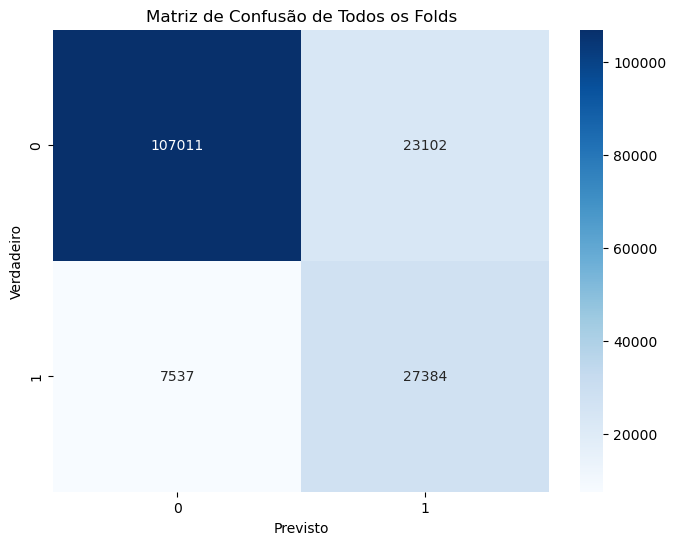

In [30]:
modelo = trainer(X, y, k=5, model=xgb)

In [ ]:
joblib.dump(modelo, 'modelo_treinado.joblib')

NameError: name 'modelo' is not defined